In [79]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
np.set_printoptions(suppress=True)

from models import DeepConditionalModel
from inn_utils import train_online_ml, compute_metrics
from process_models import simulate_lotka_volterra
from viz import (plot_true_est_scatter, 
                plot_true_est_posterior, 
                plot_losses, 
                plot_sbc, 
                plot_metrics, plot_variance)

In [38]:
tf.enable_eager_execution()

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train with summary network

In [46]:
class SequenceNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self, h_lstm_dim=64, h_dense_dim=64):
        super(SequenceNetwork, self).__init__()
        
        self.summary_part = tf.keras.Sequential([
            tf.keras.layers.Bidirectional(tf.keras.layers.CuDNNLSTM(h_lstm_dim)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Activation('elu'),
            tf.keras.layers.Dense(h_dense_dim, kernel_initializer='glorot_uniform'),
            tf.keras.layers.BatchNormalization()
        ])
    
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

In [102]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 9
epochs = 30
iterations_per_epoch = 1000
n_inv_blocks = 5
n_test = 500
n_sbc = 5000
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
simulate_lotka_volterra = partial(simulate_lotka_volterra, n_points=500)

In [103]:
X_test, theta_test = simulate_lotka_volterra(n_test)
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc)

## Create networks

In [121]:
summary_net = SequenceNetwork(h_dense_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [122]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/lv_sumnet', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/lv_sumnet/ckpt-33


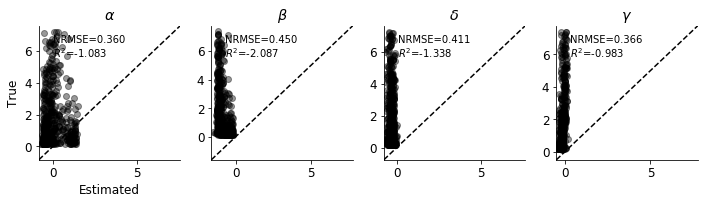

In [49]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

In [119]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model, optimizer, simulate_lotka_volterra, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, 
                            global_step=global_step)
        
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))
        theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
        plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25)
        
        # Save model
        manager.save()

## Validate

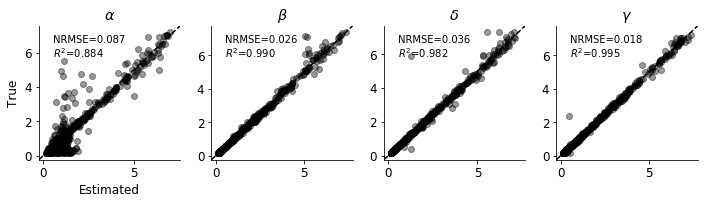

In [118]:
plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))

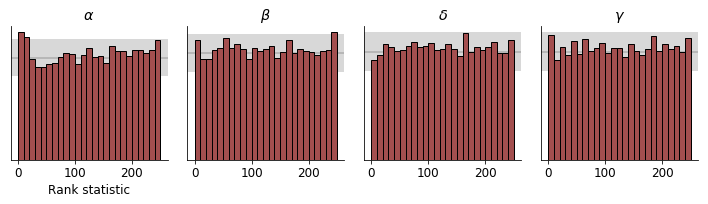

In [123]:
theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25)

# Train with summary stats

In [81]:
class NormalizationNetwork(tf.keras.Model):
    """
    Implements an LSTM summary network to summarize time-series data generated from the Ricker model.
    """
    
    def __init__(self):
        super(NormalizationNetwork, self).__init__()
        
        self.summary_part = tf.keras.layers.BatchNormalization()
        
    def call(self, x, training=True):
        
        x = self.summary_part(x, training=training)
        return x

In [82]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
epochs = 50
iterations_per_epoch = 1000
n_inv_blocks = 5
n_test = 500
n_sbc = 5000
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
simulate_lotka_volterra = partial(simulate_lotka_volterra, n_points=500, summary=True)

In [77]:
X_test, theta_test = simulate_lotka_volterra(n_test)
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc)

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [83]:
summary_net = NormalizationNetwork()
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [84]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/lv_sumstats', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


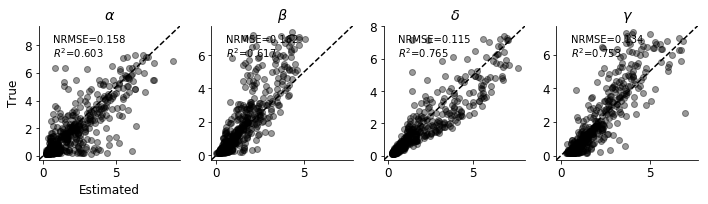

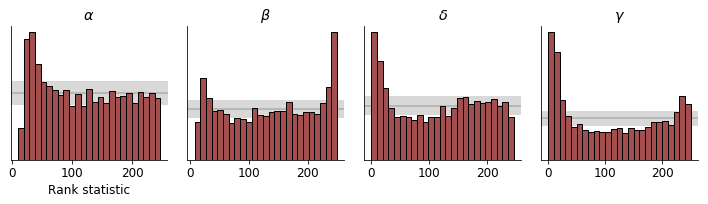

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


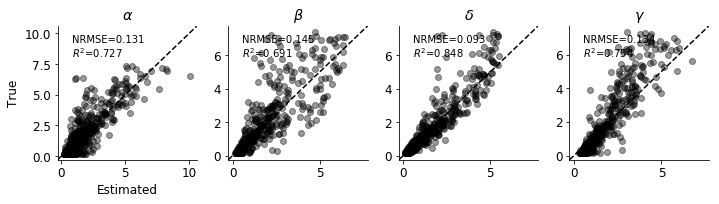

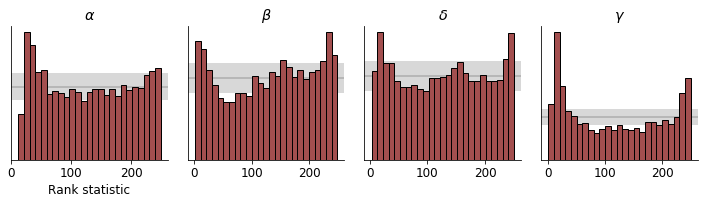

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


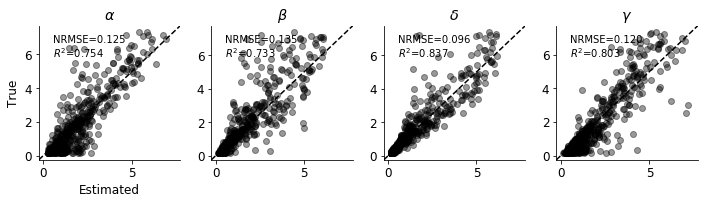

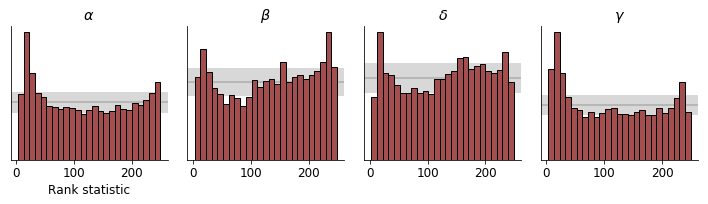

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


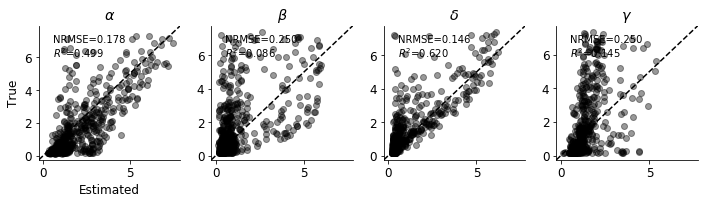

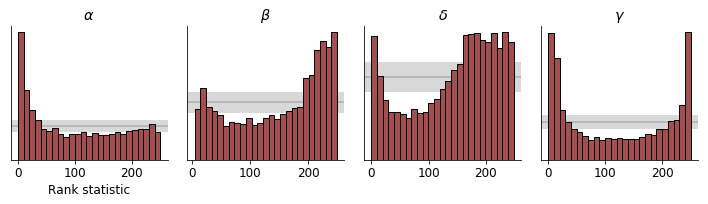

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


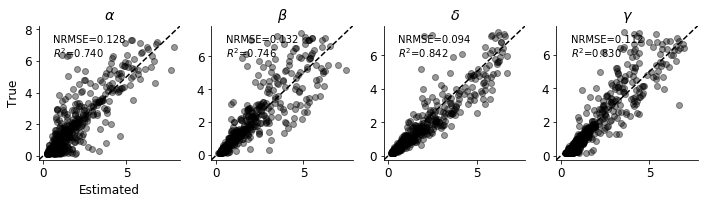

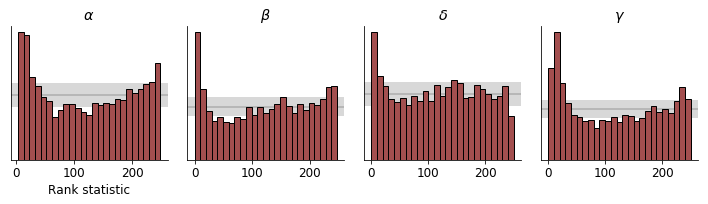

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


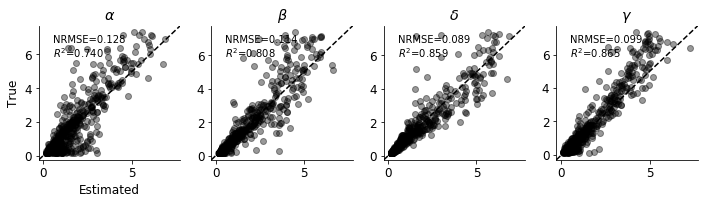

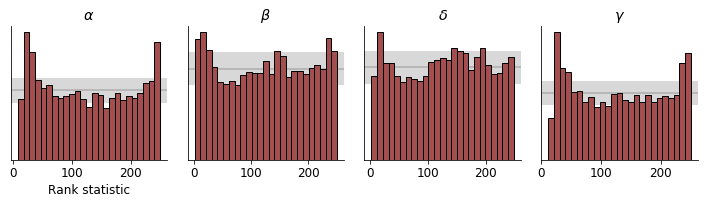

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


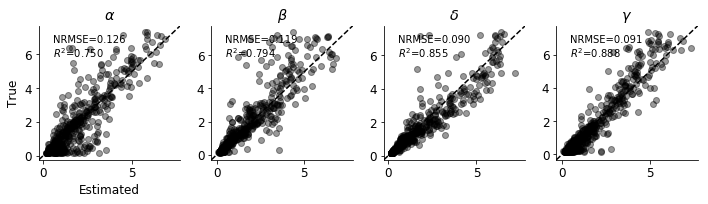

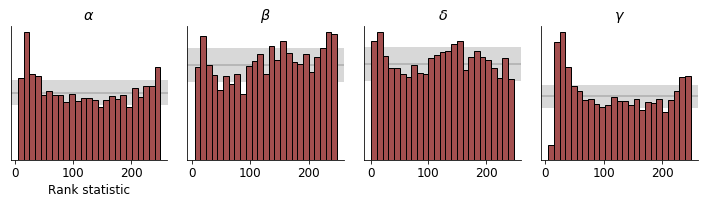

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


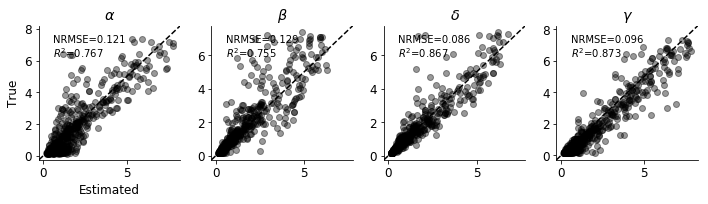

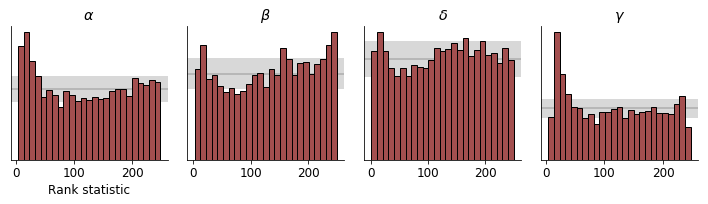

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


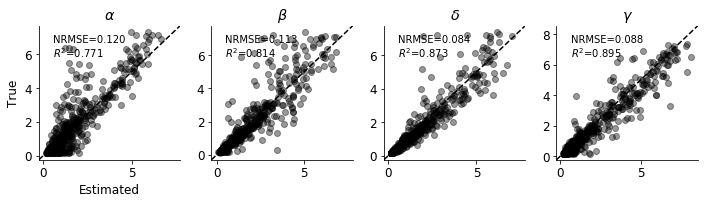

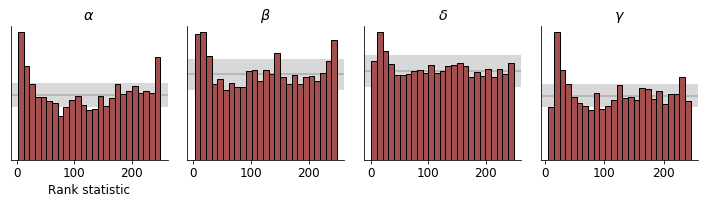

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


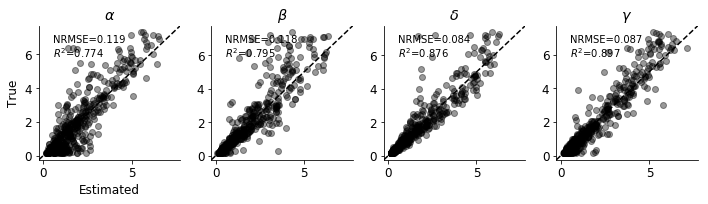

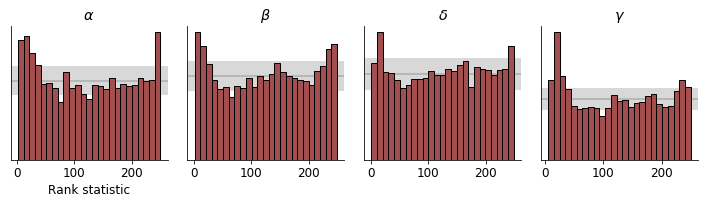

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


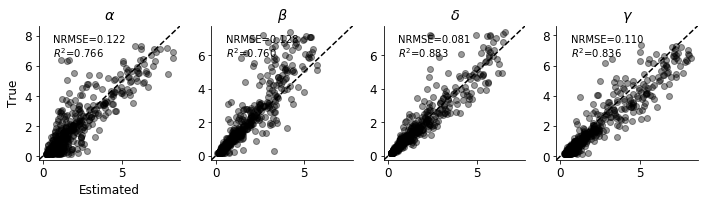

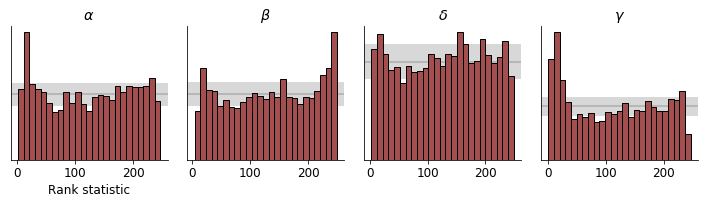

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


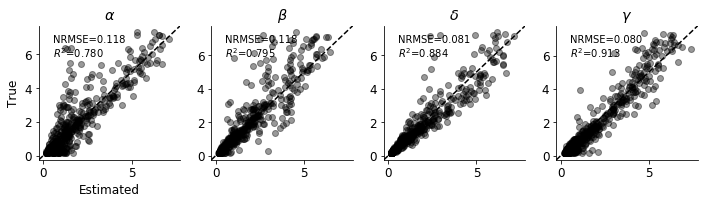

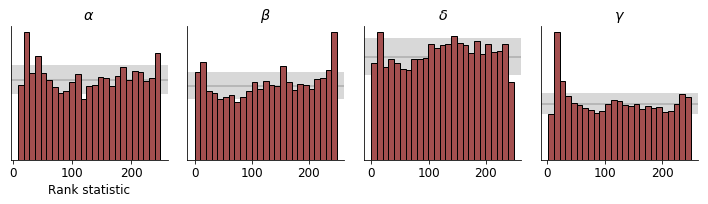

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


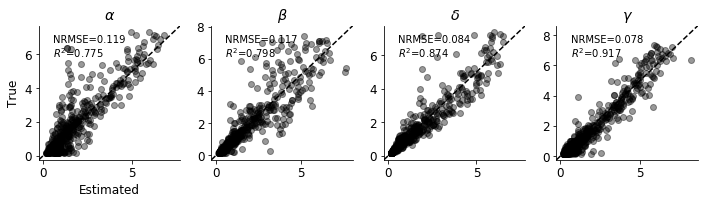

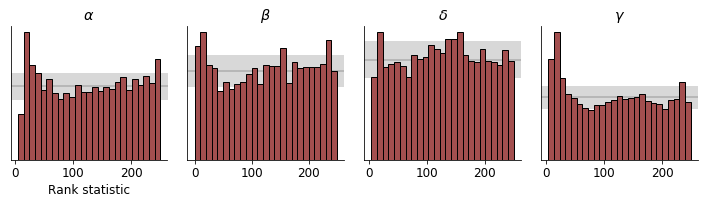

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


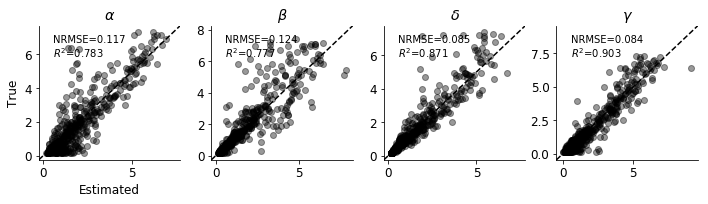

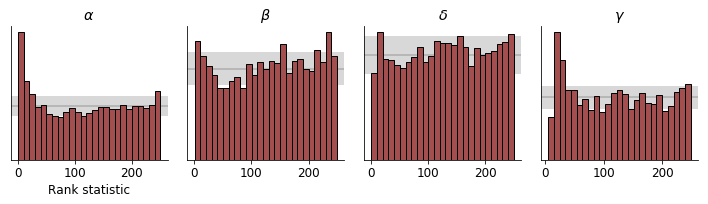

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


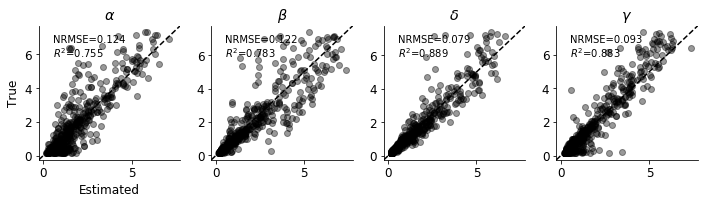

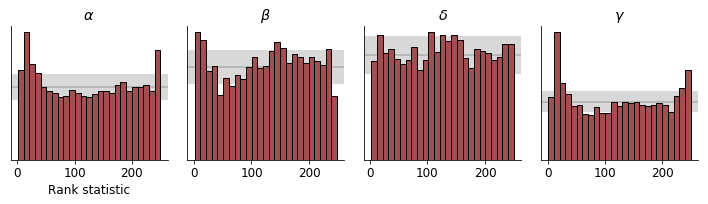

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


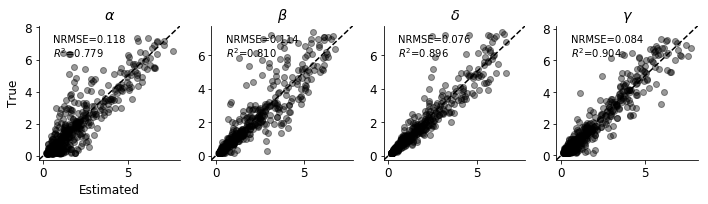

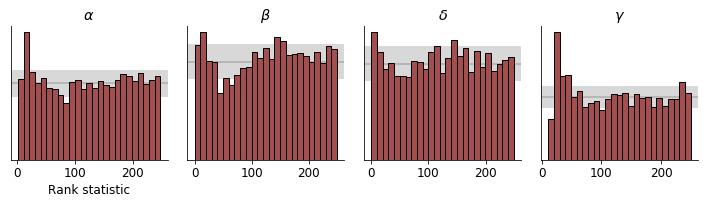

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


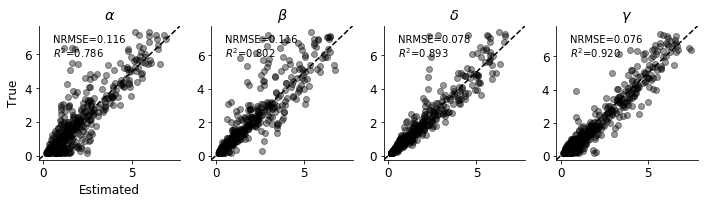

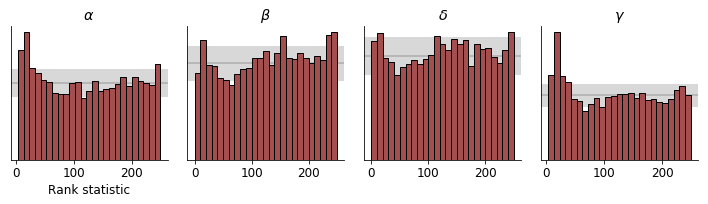

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


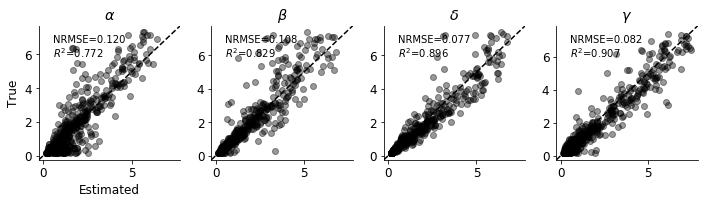

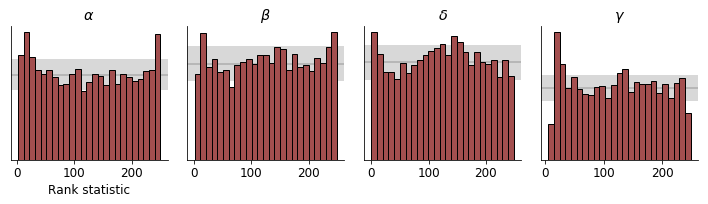

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


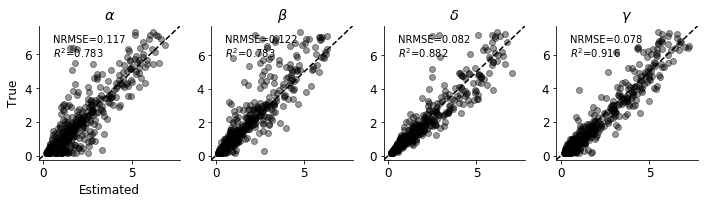

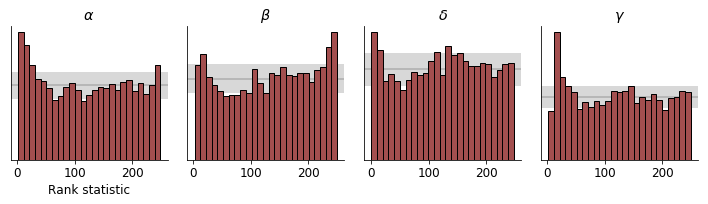

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


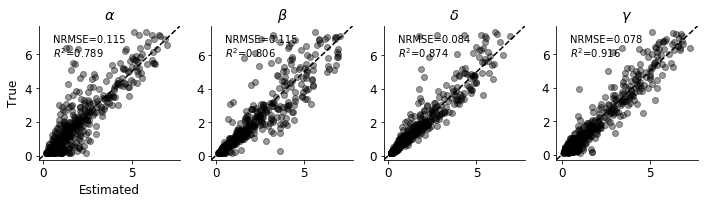

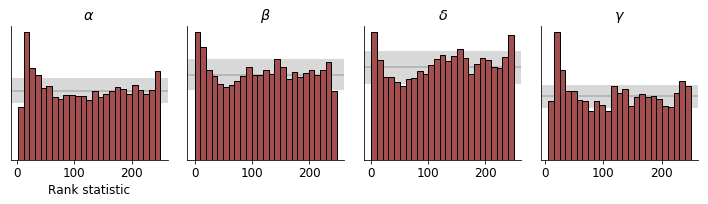

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


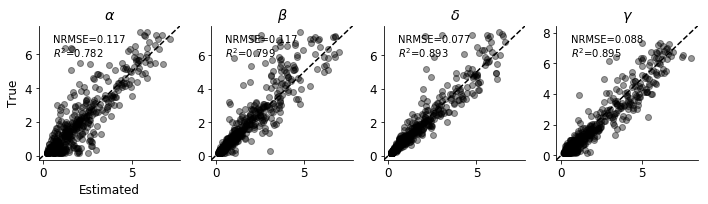

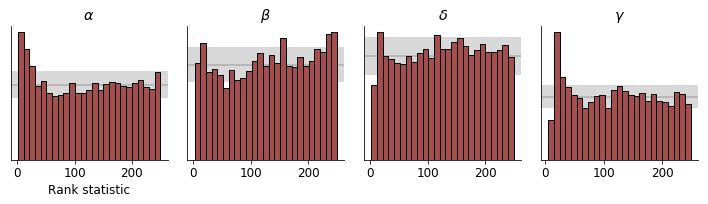

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


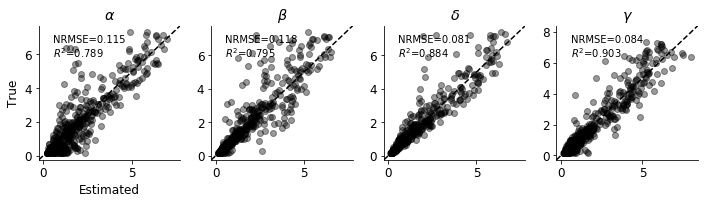

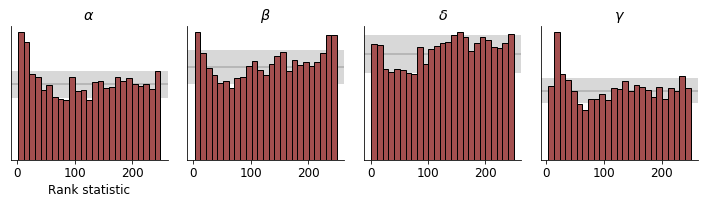

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


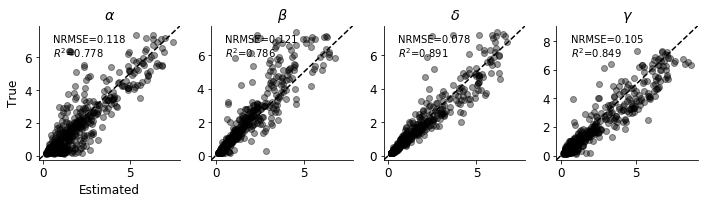

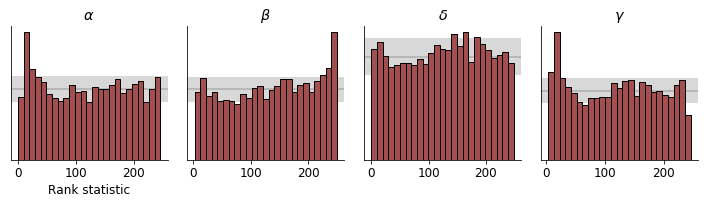

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


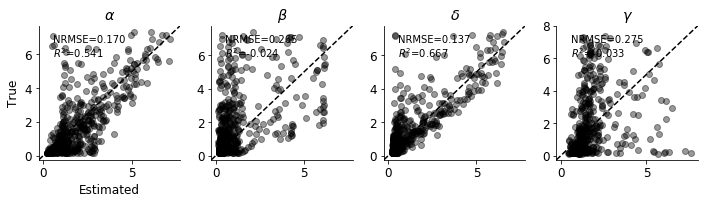

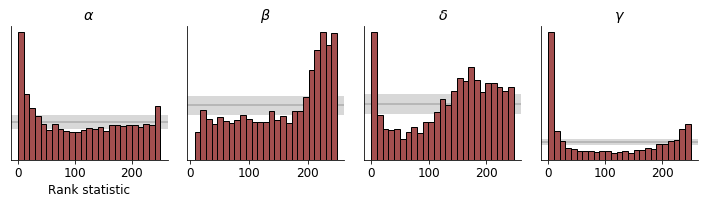

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


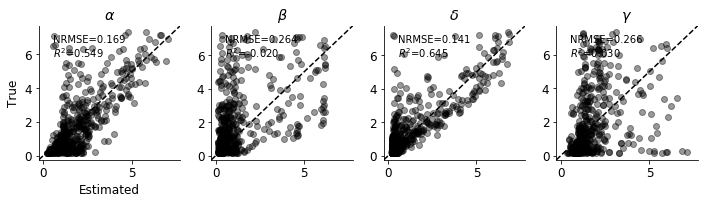

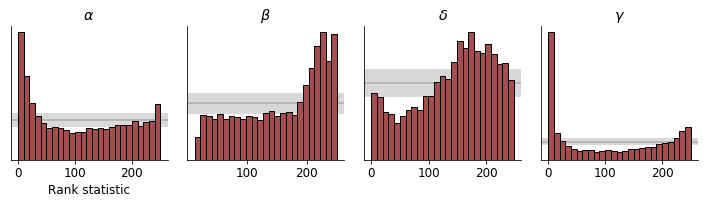

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


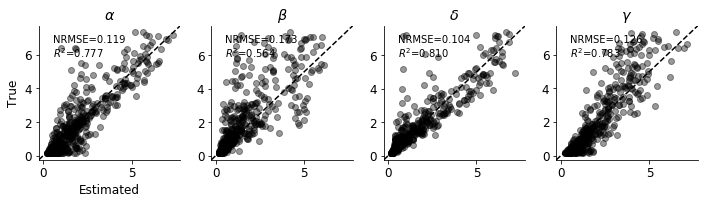

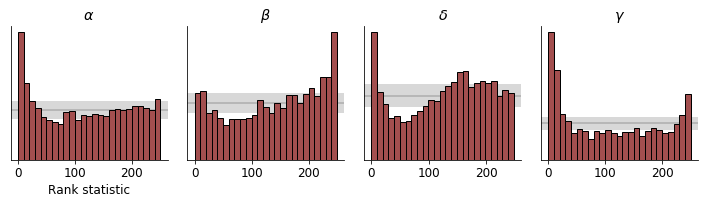

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


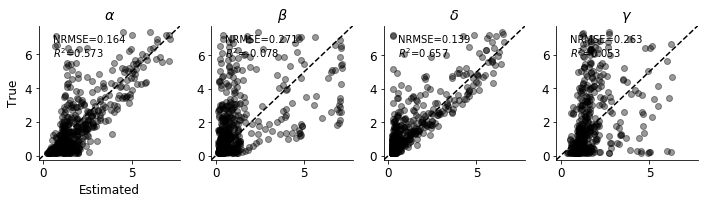

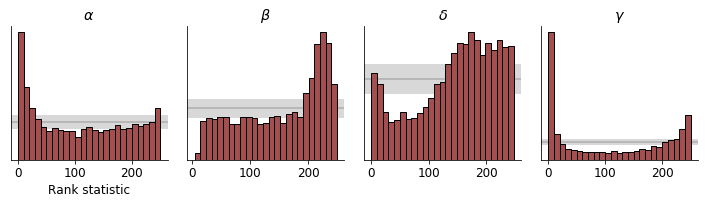

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


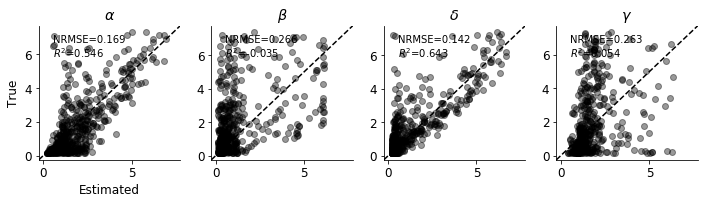

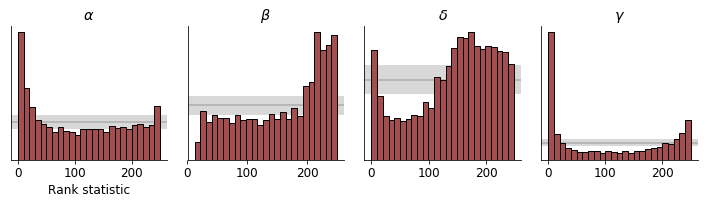

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


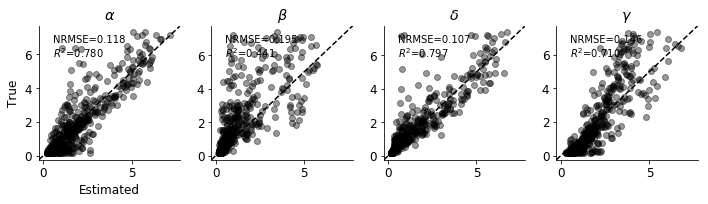

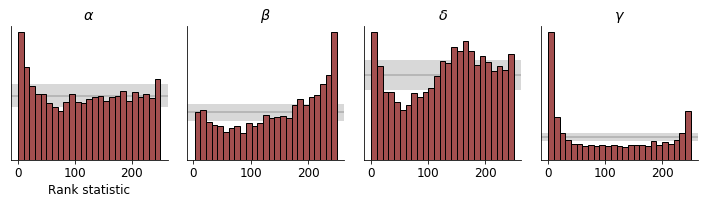

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/stefan/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


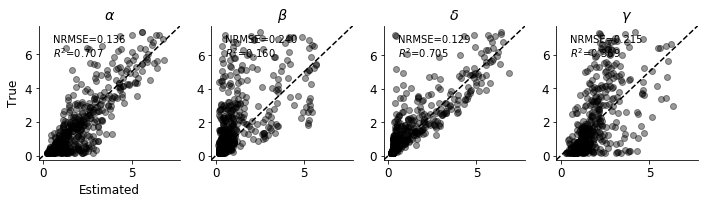

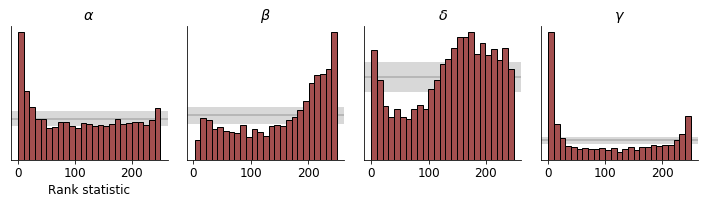

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


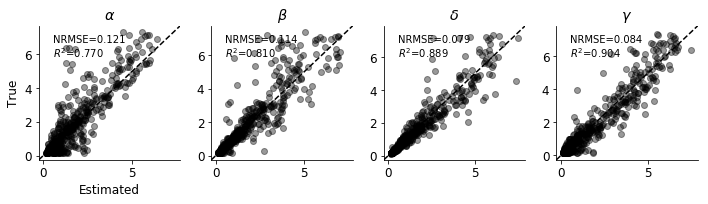

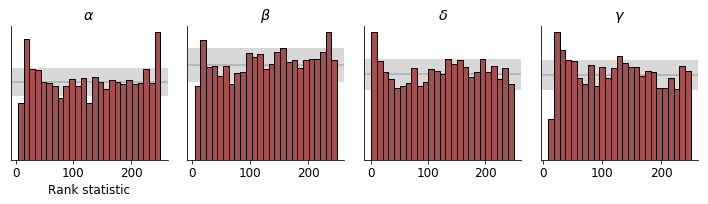

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


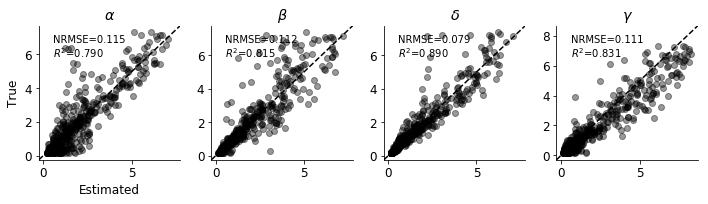

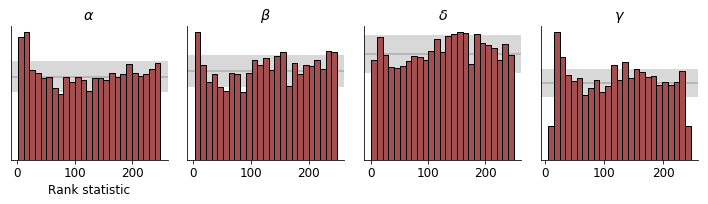

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


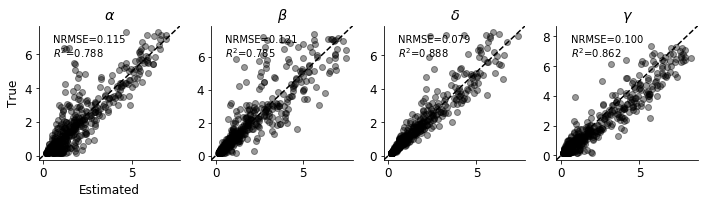

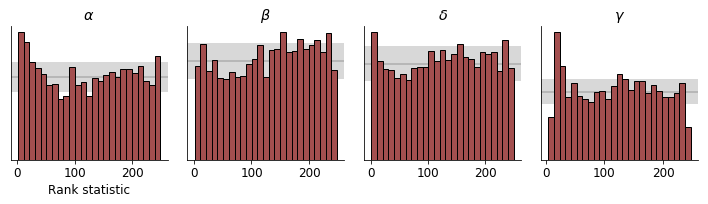

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


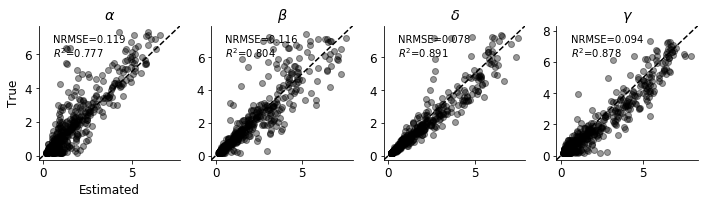

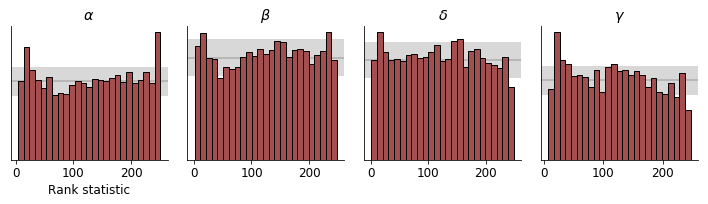

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


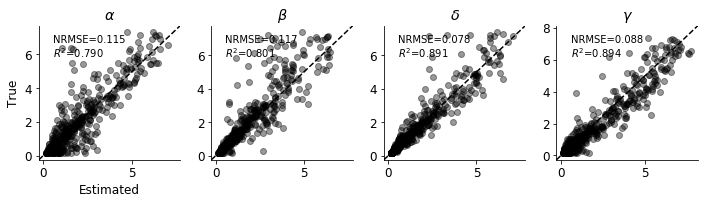

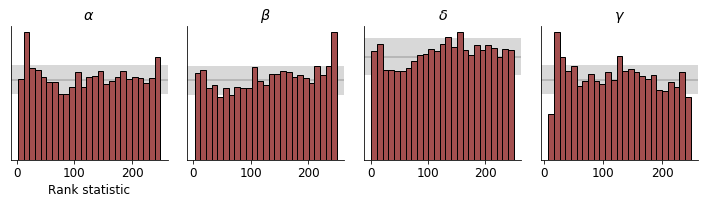

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


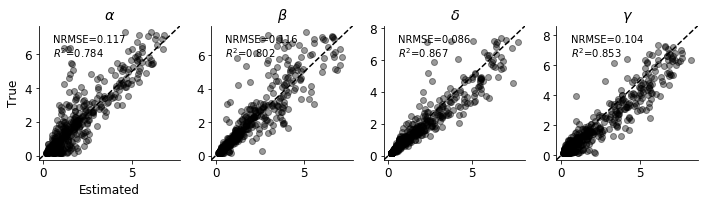

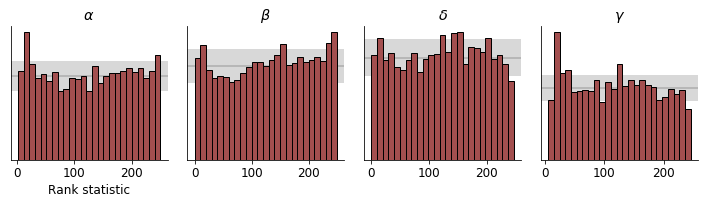

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


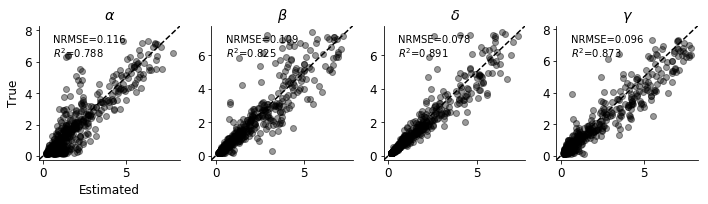

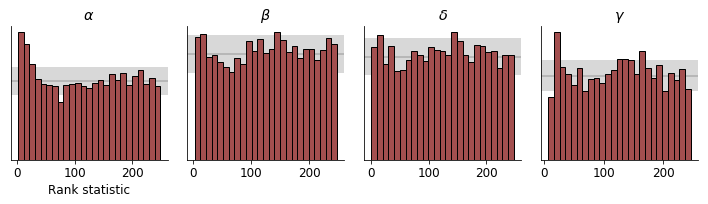

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


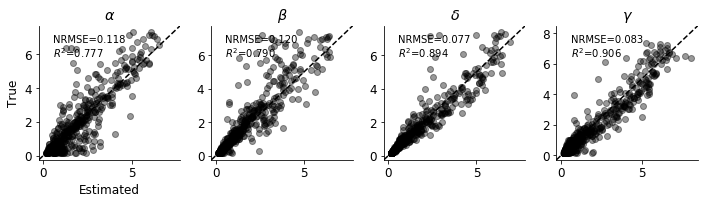

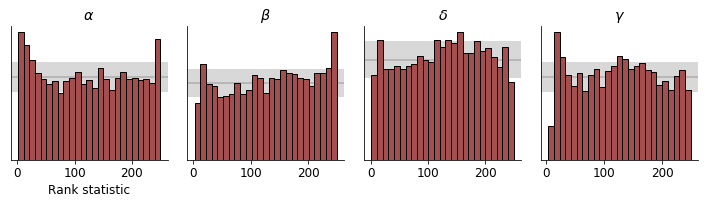

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


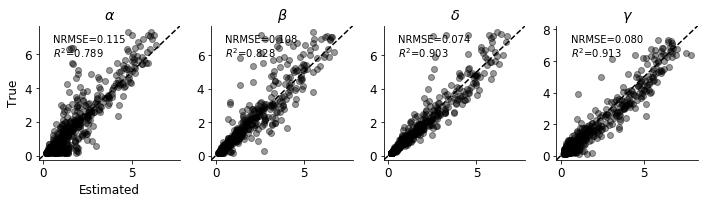

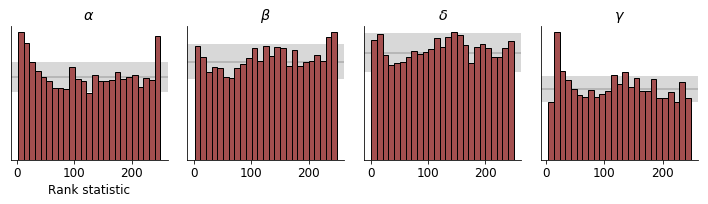

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


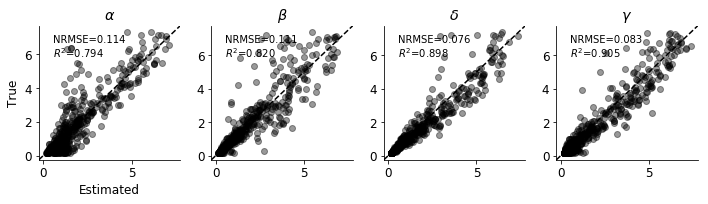

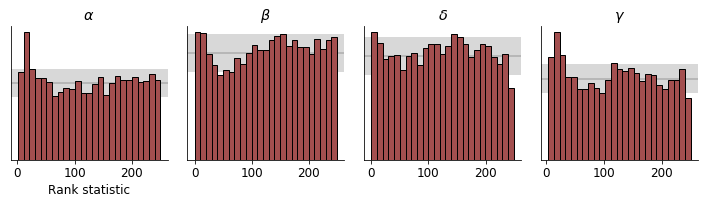

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


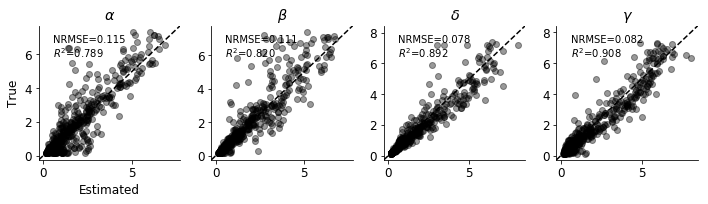

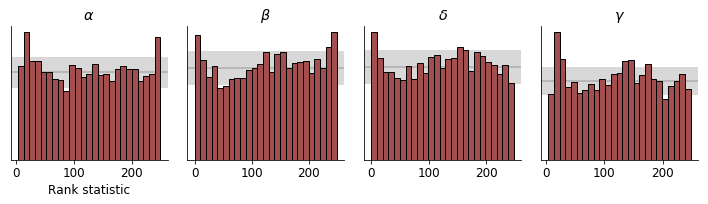

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


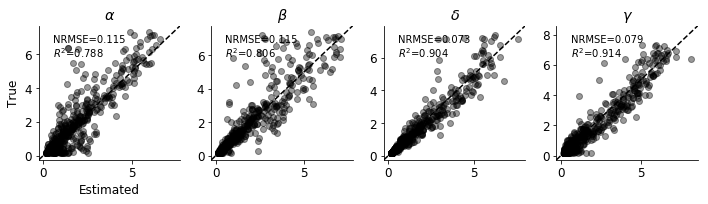

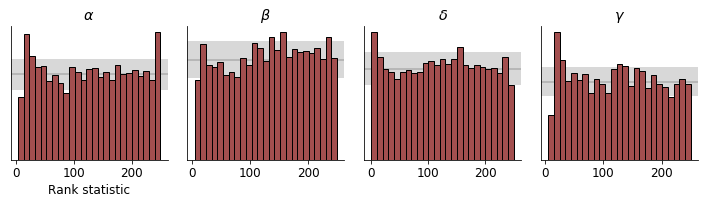

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


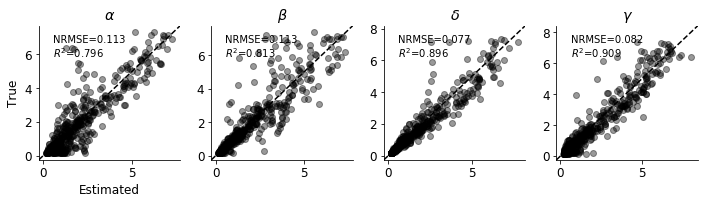

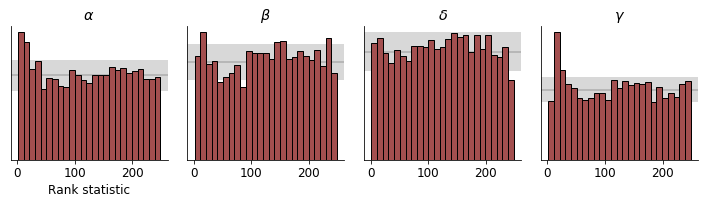

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


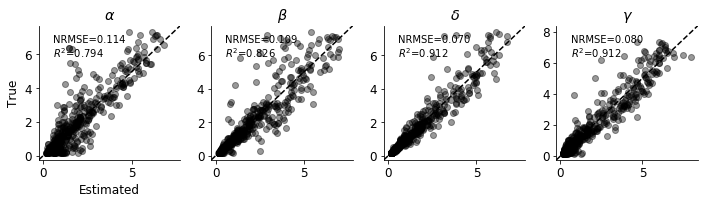

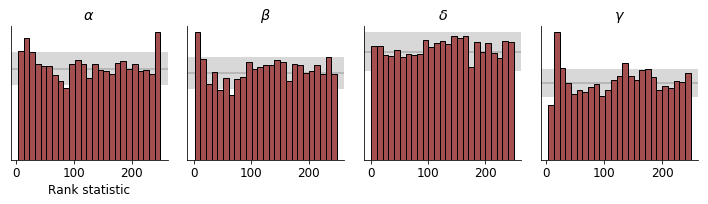

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


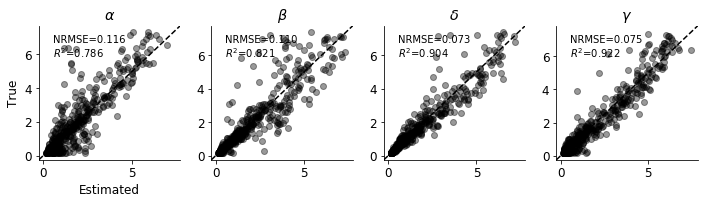

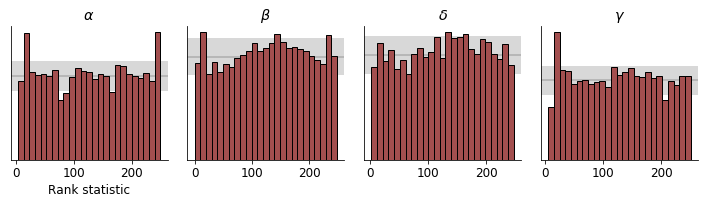

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


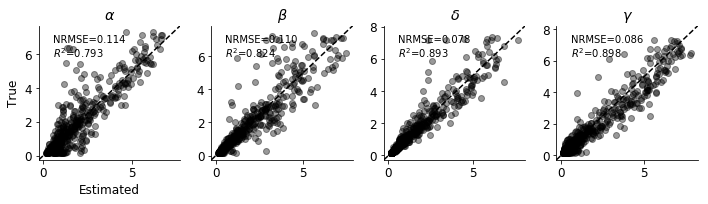

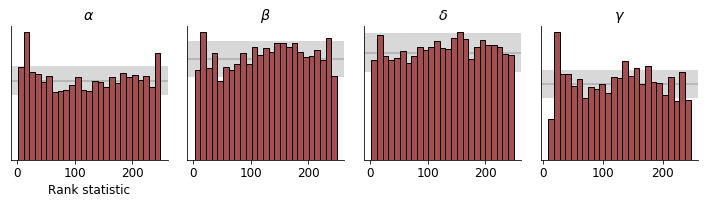

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


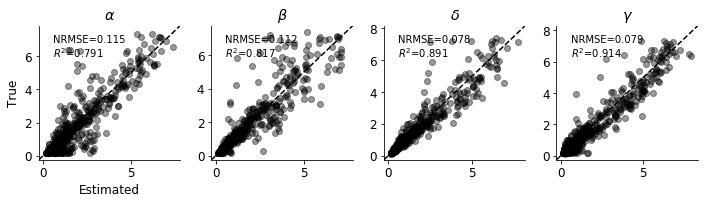

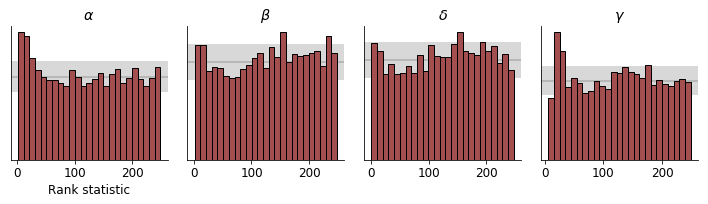

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


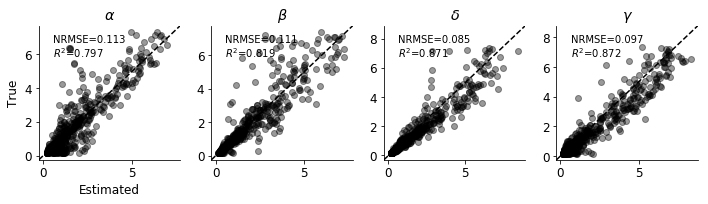

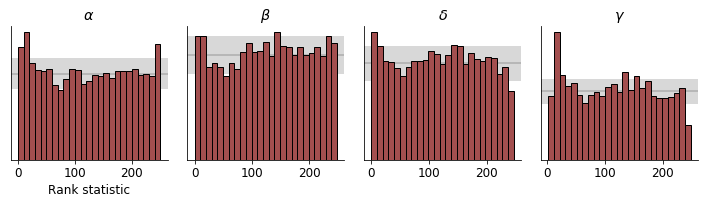

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


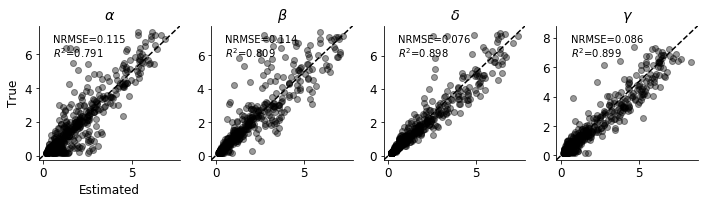

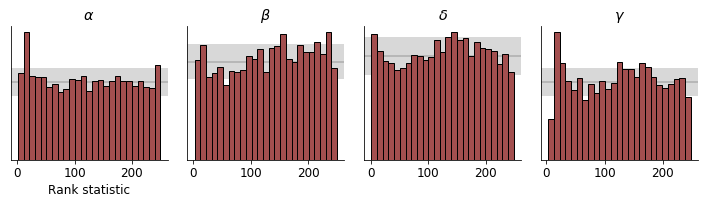

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


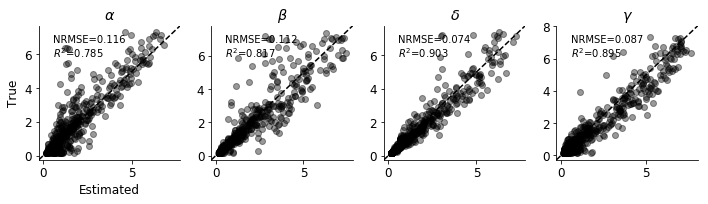

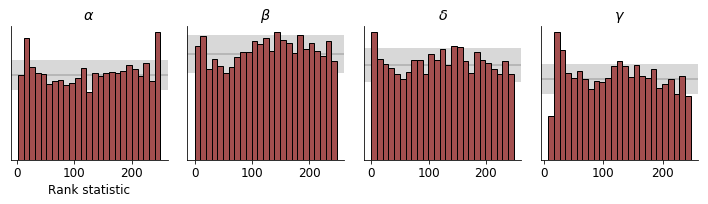


CPU times: user 14h 15min 33s, sys: 37min 34s, total: 14h 53min 8s
Wall time: 4h 54min 14s


In [85]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model, optimizer, simulate_lotka_volterra, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, 
                            global_step=global_step)
        
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))
        theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
        plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25)
        
        # Save model
        manager.save()

# Train with a large summary net

In [96]:
# --- Structure of the coupling blocks in the INN chain --- #
inv_meta = {
    'n_units': [64, 64, 64],
    'activation': 'elu',
    'w_decay': 0.00001,
    'initializer': 'glorot_uniform'
}


# --- Training hyperparameters --- #
train = False
param_names = [r'$\alpha$', r'$\beta$', r'$\delta$', r'$\gamma$']
theta_dim = 4
global_step = tfe.Variable(0, dtype=tf.int32)
batch_size = 64
summary_dim = 64
epochs = 30
iterations_per_epoch = 1000
n_inv_blocks = 5
n_test = 500
n_sbc = 5000
n_samples_posterior = 2000
starter_learning_rate = 0.0005
decay_steps = 2000
decay_rate = .95
clip_value = 5.
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, decay_steps, decay_rate)
simulate_lotka_volterra = partial(simulate_lotka_volterra, n_points=500, summary=False)

In [97]:
summary_net = SequenceNetwork(h_dense_dim=summary_dim)
model = DeepConditionalModel(inv_meta, n_inv_blocks, theta_dim, summary_net=summary_net, permute=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [100]:
X_test, theta_test = simulate_lotka_volterra(n_test)
X_sbc, theta_sbc = simulate_lotka_volterra(n_sbc)

In [98]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/lv_sumnet_large', max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


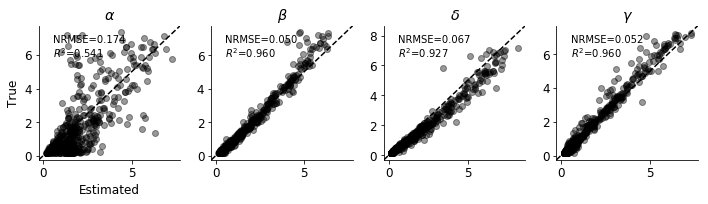

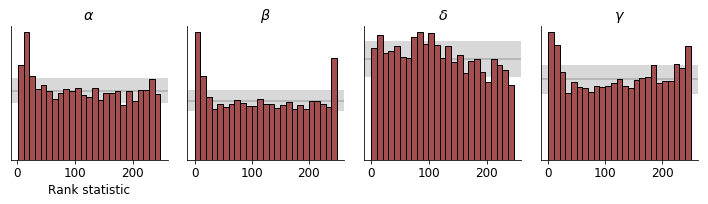

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


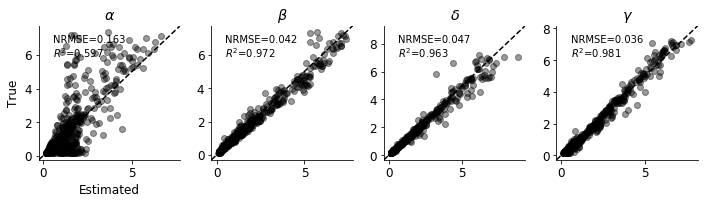

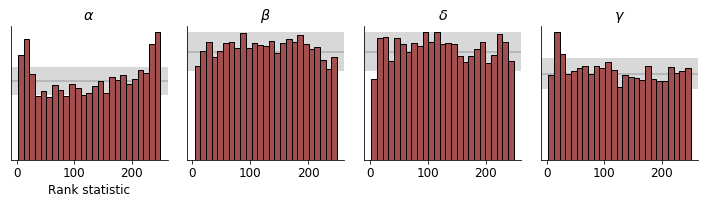

/home/stefan/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


KeyboardInterrupt: 

In [101]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online_ml(model, optimizer, simulate_lotka_volterra, iterations_per_epoch, 
                            batch_size, p_bar, clip_value=clip_value, 
                            global_step=global_step)
        
        plot_true_est_scatter(model, X_test, theta_test, n_samples_posterior, param_names, figsize=(10, 3))
        theta_samples = np.concatenate([model.sample(x, n_samples=250, to_numpy=True)
                                        for x in tf.split(X_sbc, 20, 0)], axis=0)
        plot_sbc(theta_samples, theta_sbc, param_names, figsize=(10, 3), bins=25)
        
        # Save model
        manager.save()